# Learning to apply CNN to classify digits in MNIST Dataset

In [31]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Download MNIST Dataset

Since MNIST dataset from the original author's site is difficult to load (.gz -> read in bytes -> numpy array)
I will be using the preloaded version from torchvision

In [22]:
from torchvision.transforms import ToTensor

dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=ToTensor())

In [25]:
dataset[0][0].shape

torch.Size([1, 28, 28])

In [28]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print(f"Label: {dataset.classes[label]}, ({label})")
    # Change Tensor shape (1,28,28) to image shape (28,28,1) for viewing
    plt.imshow(img.permute(1, 2, 0))

Label: 5 - five, (5)


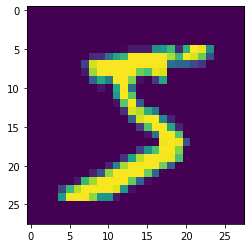

In [29]:
show_example(*dataset[0])

## Training and Validation Datasets

Split dataset into train and evaluation set

In [30]:
from torch.utils.data import random_split

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(55000, 5000)

In [32]:
from torch.utils.data.dataloader import DataLoader

batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [33]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

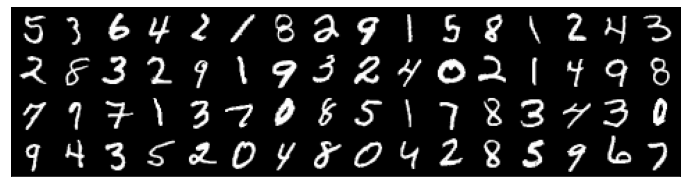

In [34]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

In [36]:
import torch.nn as nn
import torch.nn.functional as F

Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

In [37]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We will be building a LeNet Convnet Architecture for the MNIST Dataset

![LeNet-Architecture](misc/lenet.png)


In [47]:
class LeNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Since input layer is 28 x 28 (there will be some tweaks)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)       # output after maxpool: (24-2)/2 + 1 = 12
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)      # output after maxpool: (8-2)/2 + 1 = 4
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Let's test out the model to see if it works

In [49]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 1, 28, 28])
out.shape: torch.Size([64, 10])
out[0]: tensor([-0.0308, -0.0928, -0.0618,  0.1070, -0.0026,  0.0638, -0.0515, -0.0462,
         0.0626, -0.0179], grad_fn=<SelectBackward>)


In [72]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


## Import offload to GPU Capability

In [50]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [51]:
device = get_default_device()
device

device(type='cuda')

wrapping of dataset into gpu

In [57]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Define a Loss function and optimizer

In [63]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
opt_func = optim.Adam
lr = 0.001

In [64]:
# Disable gradiant calculation when evaluating
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [67]:
num_epochs = 10
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.3564, val_loss: 0.1298, val_acc: 0.9586
Epoch [1], train_loss: 0.1059, val_loss: 0.1103, val_acc: 0.9697
Epoch [2], train_loss: 0.0758, val_loss: 0.0924, val_acc: 0.9725
Epoch [3], train_loss: 0.0608, val_loss: 0.0645, val_acc: 0.9795
Epoch [4], train_loss: 0.0512, val_loss: 0.0543, val_acc: 0.9836
Epoch [5], train_loss: 0.0432, val_loss: 0.0490, val_acc: 0.9863
Epoch [6], train_loss: 0.0346, val_loss: 0.0731, val_acc: 0.9797
Epoch [7], train_loss: 0.0310, val_loss: 0.0504, val_acc: 0.9850
Epoch [8], train_loss: 0.0254, val_loss: 0.0630, val_acc: 0.9818
Epoch [9], train_loss: 0.0242, val_loss: 0.0529, val_acc: 0.9863


In [65]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

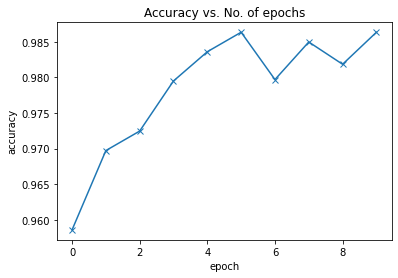

In [68]:
plot_accuracies(history)

In [69]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

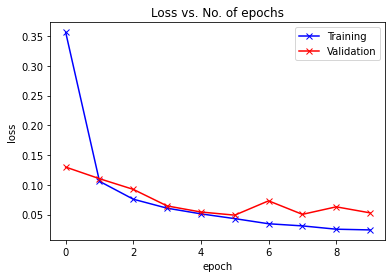

In [70]:
plot_losses(history)

## Find overall loss and accuracy on test set

In [71]:
test_loader = DeviceDataLoader(DataLoader(testset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.04006120190024376, 'val_acc': 0.9878362417221069}